# Importing Libraries and Reading CSV Files

In [1]:
import time
since = time.time()
!pip3 install python-gdcm

     |████████████████████████████████| 9.4 MB 8.1 MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
import pydicom as dicom # Dicom (Digital Imaging in Medicine) - medical image datasets, storage and transfer
import os
from tqdm import tqdm # allows you to output a smart progress bar by wrapping around any iterable
import glob # retrieve files/pathnames matching a specified pattern
import pprint # pretty-print” arbitrary Python data structures
import ast # 
from pydicom.pixel_data_handlers.util import apply_voi_lut #
import wandb #
from scipy import ndimage
from PIL import Image
import shutil
import gdcm

path = '/kaggle/input/siim-covid19-detection/'
train_image_level = pd.read_csv(path + "train_image_level.csv")
train_study_level = pd.read_csv(path + "train_study_level.csv")

train_image_level.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [3]:
train_image_level.describe()

,id,boxes,label,StudyInstanceUID
count,6334,4294,6334,6334
unique,6334,4294,4295,6054
top,09be36e1b94b_image,"[{'x': 540.4168, 'y': 1408.06092, 'width': 718...",none 1 0 0 1 1,0fd2db233deb
freq,1,1,2040,9



2040 ids without box

In [4]:
train_study_level_key = train_study_level.id.str[:-6]
training_set = pd.merge(left = train_study_level, right = train_image_level, how = 'right', left_on = train_study_level_key, right_on = 'StudyInstanceUID')
print(training_set.shape)

(6334, 9)


In [5]:
print(training_set.loc[0])

id_x                                                       5776db0cec75_study
Negative for Pneumonia                                                      0
Typical Appearance                                                          1
Indeterminate Appearance                                                    0
Atypical Appearance                                                         0
id_y                                                       000a312787f2_image
boxes                       [{'x': 789.28836, 'y': 582.43035, 'width': 102...
label                       opacity 1 789.28836 582.43035 1815.94498 2499....
StudyInstanceUID                                                 5776db0cec75
Name: 0, dtype: object


# Read Image in DCM format

## Searching Desired StudyInstanceUID in all Subfolders

In [6]:
def read_dcm(i):
    path_train = path + 'train/' + training_set.loc[i, 'StudyInstanceUID']
    #print(os.listdir(path_train))
    img_id = training_set.loc[i, 'id_y'].replace('_image','.dcm')
    
    for dirname, _, filenames in os.walk(path_train):
        for filename in filenames:
            path_img_id = os.path.join(dirname, filename)
            if path_img_id[-16:-4] == img_id:
                #print(path_img_id[-16:-4])
                break
      
    last_folder_in_path = os.listdir(path_train)[0]
    path_train = path_train + '/{}/'.format(last_folder_in_path)
    data_file = dicom.dcmread(path_img_id)#(path_train + img_id)
    return img_id, data_file

def Image_resize(img,len_x):
    img = img.resize((len_x, len_x), Image.ANTIALIAS)
    return img

_,img = read_dcm(1)
print(img)

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.70.1.39810146631291240246278118572217078765
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: 03a65300fa41
(0008, 0018) SOP Instance UID                    UI: 000c3a3f293f
(0008, 0020) Study Date                          DA: 'd09eda152722'
(0008, 0030) Study Time                          TM: '543adb46f494'
(0008, 0050) Accession Number                    SH: '1c2708371bc6'
(0008, 0060) Modality                            CS: 'CR'
(0010, 0010) Patient's Name                      PN: 'ef8c31f8dfdd'
(0010, 0020) P

# DCM Image as Pixel Array

Shape: (2320, 2832)


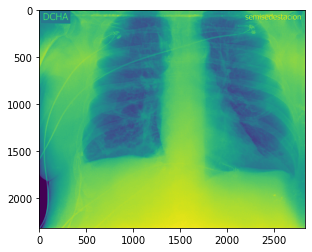

In [7]:
img_arr = img.pixel_array
plt.imshow(img_arr)
print('Shape:', img_arr.shape)

(array([  40473.,    7083.,  267588.,  756213.,  811724.,  690555.,
        1033042., 1503307., 1066989.,  393266.]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <BarContainer object of 10 artists>)

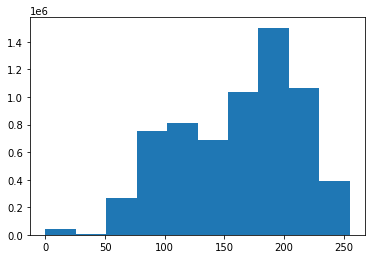

In [8]:
plt.hist(img_arr.ravel()) #calculating histogram

Image Shape: (2539, 3050)


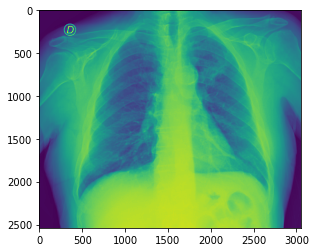

In [9]:
_,img = read_dcm(5) # Another Image
img_arr = img.pixel_array

plt.imshow(img_arr)
print('Image Shape:',img_arr.shape)

(array([ 443233.,  186707.,  528572.,  866834., 1006658., 1030330.,
        1248890., 1165411., 1121366.,  145949.]),
 array([  67. ,  469.8,  872.6, 1275.4, 1678.2, 2081. , 2483.8, 2886.6,
        3289.4, 3692.2, 4095. ]),
 <BarContainer object of 10 artists>)

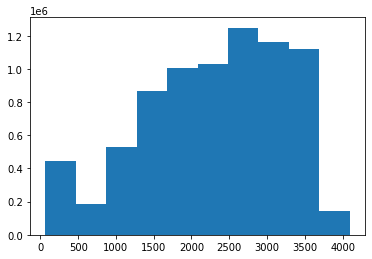

In [10]:
plt.hist(img_arr.ravel()) 

## Observation
### Some images have an intensity range of 0 to 255
### Some images have a higher intensity range.(can be 16 bit images/ 12 bit allocated)

# Edge Detection

(2539, 3050)


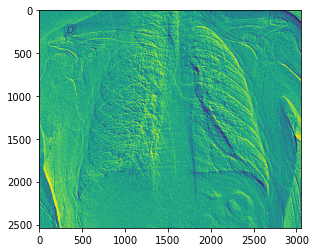

In [11]:
'''
'sobel_filters' Copied from 
https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
'''

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)

    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    return (G, theta)

mg_arr = np.array(img_arr)
#rint(img_arr.shape)
img_arr2,A = sobel_filters(img_arr)
plt.imshow(img_arr2)

print(A.shape)

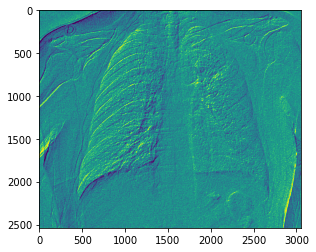

In [12]:
plt.imshow(A)


# Histogram Equalization + Converting to RGB Images

In [13]:
def To_16bit(img_arr):
    min_arr = np.amin(img_arr)
    max_arr = np.amax(img_arr)
    range_array = max_arr - min_arr

    return np.round((img_arr-min_arr)/range_array*(np.power(2,16)*3-1)) 


    
def To_RGB(img_arr): #Extend to 16 bit then segment by 8 bit top(G), 8 bit bottom(R), 8 bit overall(B)
    min_arr = np.amin(img_arr)
    max_arr = np.amax(img_arr)
    range_array = max_arr - min_arr
   
    img_arr2, A = sobel_filters(img_arr)
    
    lenx, leny = img_arr.shape
    rgbArray = np.zeros((lenx,leny,3), 'uint8')

    arr2 = np.round((img_arr-min_arr)/range_array*(np.power(2,8)-1)) #Histogram equalization
    rgbArray[:,:, 0] = arr2      #8 bit top    
    rgbArray[:,:, 1] = img_arr2  #edge magnitude     
    rgbArray[:,:, 2] = A         #edge angle
    
    
    return rgbArray    

Image Shape: (2539, 3050, 3)


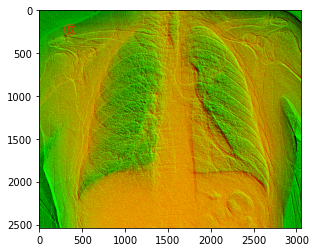

In [14]:
rgb_arr = To_RGB(img_arr)
plt.imshow(rgb_arr)
print('Image Shape:', rgb_arr.shape)

# Plotting


000a312787f2.dcm opacity
000c3a3f293f.dcm none
0012ff7358bc.dcm opacity
001398f4ff4f.dcm opacity
001bd15d1891.dcm opacity
0022227f5adf.dcm opacity
0023f02ae886.dcm none
002e9b2128d0.dcm opacity
00326161e51e.dcm opacity


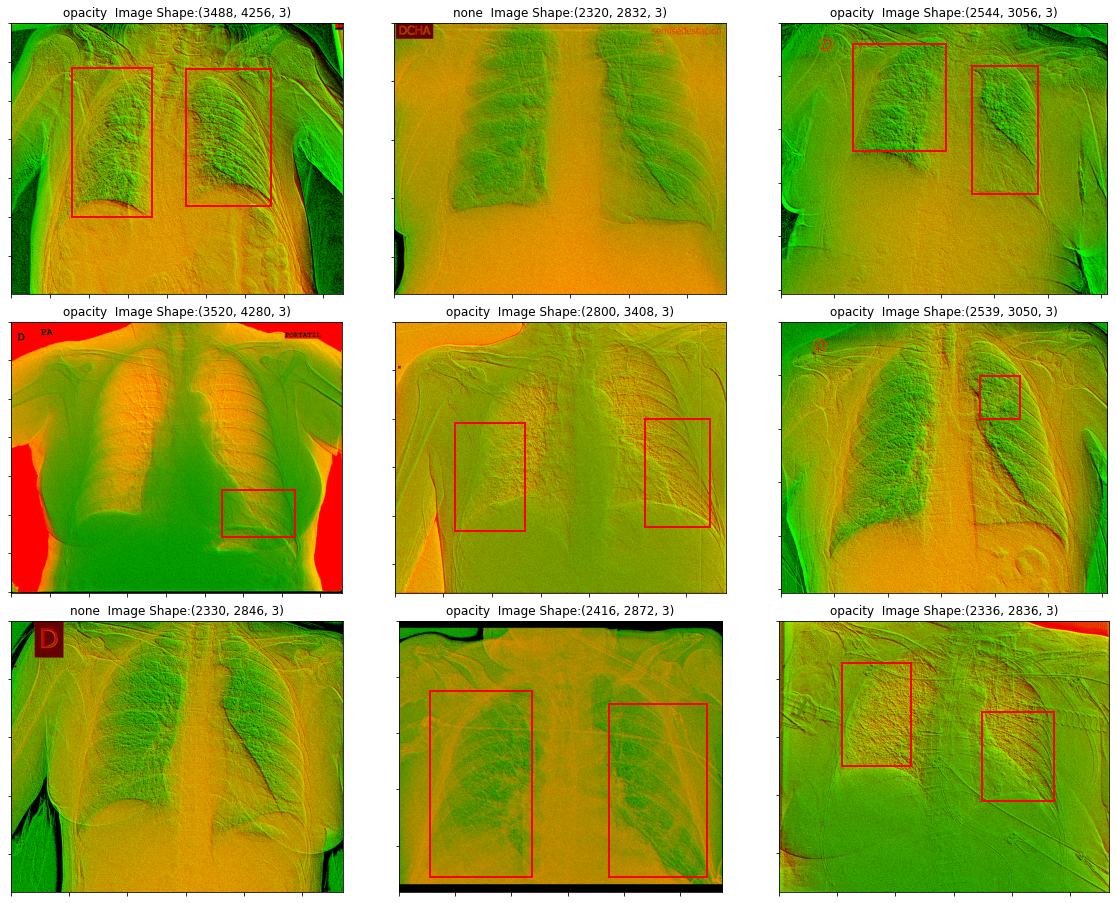

In [15]:
fig, axes = plt.subplots(3,3, figsize=(20,16))
fig.subplots_adjust(hspace=.1, wspace=.1)
axes = axes.ravel()

start_index = 0

for row in range(9):
    img_id, img = read_dcm(row + start_index)
    img = img.pixel_array
    img = To_RGB(img)
    
    print(img_id, training_set.loc[row, 'label'].split(' ')[0])
    if (training_set.loc[row + start_index,'boxes'] == training_set.loc[row + start_index,'boxes']):
        boxes = ast.literal_eval(training_set.loc[row + start_index,'boxes'])
        for box in boxes:
            p = matplotlib.patches.Rectangle((box['x'], box['y']),
                                              box['width'], box['height'],
                                              ec = 'r', fc = 'none', lw = 2.
                                            )
            axes[row].add_patch(p)
    axes[row].imshow(img, cmap = 'gray')
    axes[row].set_title(training_set.loc[row, 'label'].split(' ')[0] + '  Image Shape:' +str(img.shape))
    axes[row].set_xticklabels([])
    axes[row].set_yticklabels([])

In [16]:
time_elapsed = time.time() - since
print('Time from start {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

Time from start 0m 45s


In [17]:
folderlocation = './Images'
if not os.path.exists(folderlocation):
        os.mkdir(folderlocation)

for iter_name in ['train', 'val', 'test']:
    folderlocation = './Images/' + iter_name
    if not os.path.exists(folderlocation):
            os.mkdir(folderlocation)
            
    folderlocation = './Images/' + iter_name +'/none'
    if not os.path.exists(folderlocation):
            os.mkdir(folderlocation)
            
    folderlocation = './Images/' + iter_name +'/opacity'
    if not os.path.exists(folderlocation):
            os.mkdir(folderlocation)
    


In [18]:
iter_split= 0 
folderlocation = './Images/'

for row in range(len(training_set)): # len(training_set)
    img_id, img = read_dcm(row)
    img = img.pixel_array
    img = To_RGB(img)
    iter_split = iter_split +1
    
    img_destination = folderlocation +'train/'+ training_set.loc[row, 'label'].split(' ')[0] +'/'+img_id[:-4] +'.jpeg'
    
    if iter_split%20 == 19:
        img_destination = folderlocation +'test/'+ training_set.loc[row, 'label'].split(' ')[0] +'/'+img_id[:-4] +'.jpeg'
    if iter_split%20 == 18:
        img_destination = folderlocation +'val/'+ training_set.loc[row, 'label'].split(' ')[0] +'/'+img_id[:-4] +'.jpeg'
        
    im = Image.fromarray(img)
    im = Image_resize(im,512)
    im.save(img_destination)
    
    
    if row%500 == 499:
        time_elapsed = time.time() - since
        print('Time from start {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Percentage Complete:', np.round(10000*(row+1)/6334)/100)
    
    
print('100% Complete.')    

/opt/conda/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:341: UserWarning: The length of the pixel data in the dataset (13262360 bytes) indicates it contains excess padding. 216296 bytes will be removed from the end of the data
  warnings.warn(msg)


Time from start 13m 52s
Percentage Complete: 7.89
Time from start 26m 41s
Percentage Complete: 15.79
Time from start 40m 7s
Percentage Complete: 23.68
Time from start 53m 40s
Percentage Complete: 31.58
Time from start 67m 17s
Percentage Complete: 39.47
Time from start 80m 15s
Percentage Complete: 47.36
Time from start 93m 35s
Percentage Complete: 55.26
Time from start 106m 18s
Percentage Complete: 63.15
Time from start 119m 44s
Percentage Complete: 71.05
Time from start 133m 6s
Percentage Complete: 78.94
Time from start 146m 28s
Percentage Complete: 86.83
Time from start 160m 42s
Percentage Complete: 94.73
100% Complete.


In [19]:
shutil.make_archive('SIIM-FISABIO-RSNA-JPEG', 'zip', folderlocation)
shutil.rmtree(folderlocation)